# Reviewing new EPMC evidence


For more details on the scope of this ticket, see: [#1867](https://github.com/opentargets/platform/issues/1867)


## Consequences

Counts:

```
Old data evidence count:    6_461_278
Old data target count:         19_942
Old data disease count:         8_510
Old data association count:   960_047

New data evidence count:    8_799_204
New data target count:         26_636
New data disease count:        10_081
New data association count: 8_799_204
```


### Fetching epmc evidence data from google buckets:

```bash
TARGET_DIR='/Users/dsuveges/project_data/epmc_evidence'

# Fetching old evidence:
gsutil cp -r gs://otar000-evidence_input/EPMC/json/epmc-2021-11-08.json.gz  ${TARGET_DIR}

# Fetching new evidence:
gsutil cp -r gs://ot-snapshots/literature/20210920/new_model/evidence ${TARGET_DIR}/

# Renaming the new evidence file:
mv ${TARGET_DIR}/evidence ${TARGET_DIR}/epmc_new_evid_2021.10.25.parquet

# Fetching old associations:
gsutil cp -r gs://open-targets-pre-data-releases/21.11.2/output/etl/parquet/associationByDatasourceDirect ${TARGET_DIR}

# Rename:
mv ${TARGET_DIR}/associationByDatasourceDirect ${TARGET_DIR}/associations_21.11.2.parquet

# Fetching uniprot evidence as positive controls:
gsutil cp -r gs://open-targets-data-releases/21.11/input/evidence-files/uniprot-2021-10-11.json.gz ~/project_data
```

In [104]:
from pyspark.sql.functions import (
    col, udf, struct, lit, split, regexp_replace, create_map, min as spark_min, max as spark_max,
    count, sum as spar_sum, explode, when
)
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from itertools import chain


# for heatmap:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# establish spark connection
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '15g')
    .set('spark.executor.memory', '15g')
    .set('spark.driver.maxResultSize', '0')
)
spark = (
    SparkSession.builder
    .config(conf=sparkConf)
    .master('local[*]')
    .getOrCreate()
)

In [72]:
# Reading new dataset:
new_data = (
    spark.read.parquet('/Users/dsuveges/project_data/epmc_evidence/epmc_new_evid_2021.10.25.parquet')
    .drop('datasourceId', 'datatypeId', '')
    .persist()
) 
old_data = (
    spark.read.json('/Users/dsuveges/project_data/epmc_evidence/epmc-2021-11-08.json.gz')
    .drop('datasourceId', 'datatypeId')
    .persist()
)

In [10]:
old_data.show(1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 diseaseFromSourceMappedId | Orphanet_672                                                                                                                                                                                                                                                                                                                                                                          
 literature                | [10022965]                                                                                                                                                         

In [11]:
new_data.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------------------
 targetFromSourceId            | ENSG00000000419   
 diseaseFromSourceMappedId     | EFO_0005545       
 resourceScore                 | 0.55456124965856  
 similarity                    | 0.443648999726848 
 harmonicSimilarity            | 0.55456124965856  
 sharedPublicationCount        | 2                 
 meanTargetFreqPerPub          | 11.0              
 meanDiseaseFreqPerPub         | 1.0               
 harmonicCooccurrenceSentiment | 0.0               
 cooccurredPublicationCount    | 0                 
only showing top 1 row



Reading data is done. 

### Evidence, association count


In [15]:
for label, data in {'Old data': old_data, 'New data': new_data}.items():
    print(f'{label} evidence count: {data.count()}')
    print(f"{label} target count: {data.select('targetFromSourceId').distinct().count()}")
    print(f"{label} disease count: {data.select('diseaseFromSourceMappedId').distinct().count()}")
    print(f"{label} association count: {data.select('targetFromSourceId', 'diseaseFromSourceMappedId').distinct().count()}")

Old data evidence count: 6461278
Old data target count: 19942
Old data disease count: 8510
Old data association count: 960047
New data evidence count: 8799204
New data target count: 26636
New data disease count: 10081
New data association count: 8799204


In [73]:

old_assoc = (
    spark.read.parquet('/Users/dsuveges/project_data/epmc_evidence/associations_21.11.2.parquet')
    .filter(col('datasourceId') == 'europepmc')
    .select('evidenceCount', 'score', 'targetId', 'diseaseId')
    .persist()
)

In [30]:
print('old association scores:')
print(old_assoc.select('score').describe().show())
print('\nnew association scores:')
print(new_data.select('resourceScore').describe().show())

old association scores:
+-------+--------------------+
|summary|               score|
+-------+--------------------+
|  count|              960042|
|   mean| 0.08959146448081354|
| stddev| 0.13775595348075892|
|    min|0.009118961964174315|
|    max|  0.9993001621453167|
+-------+--------------------+

None

new association scores:
+-------+--------------------+
|summary|       resourceScore|
+-------+--------------------+
|  count|             8799204|
|   mean| 0.16149119849097576|
| stddev| 0.14877979394177998|
|    min|0.010000096158440226|
|    max|  1.5258354617658982|
+-------+--------------------+

None


In [37]:
merged_associations = (
    new_data
    .withColumnRenamed('diseaseFromSourceMappedId', 'diseaseId')
    .withColumnRenamed('targetFromSourceId', 'targetId')
    .join(old_assoc, on=['diseaseId', 'targetId'], how='inner')
    .select('diseaseId', 'targetId', 'score', 'resourceScore', 'evidenceCount')
    .toPandas()
)

<AxesSubplot:xlabel='score', ylabel='resourceScore'>

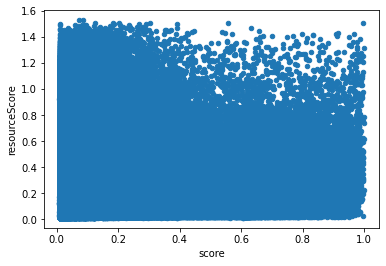

In [38]:
merged_associations.plot.scatter('score', 'resourceScore', )

In [40]:
# Initializing a large matrix with zeroes:
heatmap = np.zeros((21,21))

# Function to get the bin for a given l2g score value:
rounding = lambda value: int(value*20)

# Collate data and fill in the matrix with the count:
for i, value in (
    merged_associations
    .apply(lambda row: (rounding(row['score']), rounding(row['resourceScore']/1.6)), axis=1)
    .value_counts()
    .iteritems()
):
    heatmap[i[0],i[1]] = value
    


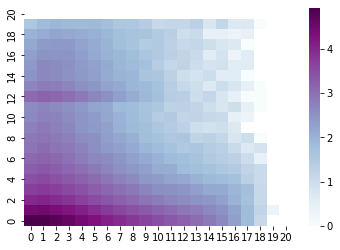

In [58]:
# removing zeroes:
for index_x, row in enumerate(heatmap):
    for index_y, value in enumerate(row):
        if value == 0:
            heatmap[index_x, index_y] = None

# Let's see the correlation between the two l2g scores:
ax = sns.heatmap(np.log10(heatmap, where=lambda x: x > 0), cmap='BuPu')
ax.invert_yaxis()
plt.show()

In [62]:
merged_associations.head().apply(lambda row: row['score'] - row['resourceScore'], axis=1)

0   -0.240064
1   -0.286018
2   -0.057982
3    0.086374
4    0.384338
dtype: float64

## Where are we losing associations/evidence

I was curious if there are a large number of evidence/association which were highly scored in the old dataset, but no longer in the new one. 

**Process:**

1. Filter the previously merged dataset based to associatinos which got score higher than 0.8 in the old dataset, but lower than 0.2 in the new. 
2. Map EFO ids to diease label to have and idea what we are losing.

In [90]:
big_loss = (
    merged_associations
    
    # Select high score associations:
    .loc[lambda df: df.score > 0.8]
    
    # Measure how the new evidence scores:
    .assign(
        drop = lambda df: df.score - df.resourceScore
    )
    
    # Filter for the association where the association score decreased by more than:
    .loc[lambda df: df['drop'] > 0.7]
)

In [91]:
print(f'Number of association with big loss: {len(big_loss)}')
print(f'Number of unique targets: {len(big_loss.targetId.unique())}')
print(f'Number of unique diseases: {len(big_loss.diseaseId.unique())}')

Number of association with big loss: 1372
Number of unique targets: 807
Number of unique diseases: 93


In [92]:
big_loss.head()

,diseaseId,targetId,score,resourceScore,evidenceCount,drop
303,EFO_0000311,ENSG00000135318,0.849910,0.029614,265,0.820296
538,EFO_0000544,ENSG00000196262,0.928894,0.128010,140,0.800884
584,EFO_0000616,ENSG00000084093,0.936475,0.016816,99,0.919660
587,EFO_0000616,ENSG00000101144,0.914945,0.125270,112,0.789675
3375,EFO_0000182,ENSG00000081041,0.809479,0.023147,25,0.786332


In [94]:
from requests import get
import pandas as pd

def EFO_id2label(efo_id):
    URL = 'https://www.ebi.ac.uk/ols/api/terms?short_form'
    
    response = get(f'{URL}={efo_id}')
    
    try:
        data = response.json()
    except:
        print(f'failed to fetch EFO data for id: {efo_id}')
        return None
    
    if data['page']['totalElements'] == 0:
        print(f'No EFO data for id: {efo_id}')
        return None
    
    for term in data['_embedded']['terms']:
        if term['ontology_name'] != 'efo':
            continue
        return term['label']
    
    
pd.Series(big_loss.diseaseId.unique()).head().apply(EFO_id2label)

0                      cancer
1                   infection
2                    neoplasm
3    hepatocellular carcinoma
4     glioblastoma multiforme
dtype: object

In [97]:

# Get disease label for all ids:
disease_annotation = (
    pd.DataFrame(big_loss.diseaseId.unique(), columns=['diseaseId'])
    .assign(diseaseLabel = lambda df: df.diseaseId.apply(EFO_id2label))
)

# Join with original table:
big_loss_labelled = (
    big_loss
    .merge(disease_annotation, on='diseaseId', how='left')
)

big_loss_labelled.head()

,diseaseId,targetId,score,resourceScore,evidenceCount,drop,diseaseLabel
0,EFO_0000311,ENSG00000135318,0.849910,0.029614,265,0.820296,cancer
1,EFO_0000544,ENSG00000196262,0.928894,0.128010,140,0.800884,infection
2,EFO_0000616,ENSG00000084093,0.936475,0.016816,99,0.919660,neoplasm
3,EFO_0000616,ENSG00000101144,0.914945,0.125270,112,0.789675,neoplasm
4,EFO_0000182,ENSG00000081041,0.809479,0.023147,25,0.786332,hepatocellular carcinoma


In [108]:
print(
    big_loss_labelled
    .groupby('diseaseLabel')
    .agg({
        'drop': np.mean,
        'targetId': len,
        'evidenceCount': sum
    })
    .rename(columns={
        'drop': 'average_assoc_score_decrease',
        'targetId': 'association_count',
        'evidenceCount': 'evidence_count'
    })
    .reset_index()
    .head(100)
)

                    diseaseLabel  average_assoc_score_decrease  \
0            Alzheimer's disease                      0.781007   
1                       Chordoma                      0.728600   
2                Cystic fibrosis                      0.717124   
3             Huntington disease                      0.784763   
4            Leukoencephalopathy                      0.752595   
..                           ...                           ...   
87                        stroke                      0.744659   
88  systemic lupus erythematosus                      0.778555   
89      type I diabetes mellitus                      0.703698   
90     type II diabetes mellitus                      0.704683   
91                  urolithiasis                      0.719114   

    association_count  evidence_count  
0                  21            2828  
1                   1              53  
2                   2              73  
3                   1             233  
4      

In [107]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Compare performance against Uniprot association

We believe Uniprot associations are excellent positive control set as those associations are also based on manual curation of the literature.

In [57]:
# Reading target. Required to map uniprot identifiers:
target_table = (
    spark.read.parquet('/Users/dsuveges/project_data/target_index/21.11.parquet/')
    .filter(col('proteinIds').isNotNull())
    .select(col('id').alias('targetId'), 'approvedSymbol', explode(col('proteinIds')).alias('proteinId'))
    .withColumn('targetFromSourceId', col('proteinId.id'))
    .drop('proteinId')
    .distinct()
    .persist()
)

# Reading positive controls + join with gene identifiers:
poscon = (
    spark.read.json('/Users/dsuveges/project_data/uniprot-2021-10-11.json.gz')
    .select(
        'confidence', 'diseaseFromSourceMappedId', 
        'targetFromSourceId', 'targetModulation',
        explode(col('literature')).alias('pmid')
    )
    .join(target_table, on='targetFromSourceId', how='left')
    .filter(col('targetId').isNotNull())
    .persist()
)

poscon.show()

+------------------+----------+-------------------------+----------------+--------+---------------+--------------+
|targetFromSourceId|confidence|diseaseFromSourceMappedId|targetModulation|    pmid|       targetId|approvedSymbol|
+------------------+----------+-------------------------+----------------+--------+---------------+--------------+
|            P04150|      high|             Orphanet_786|      up_or_down|15769988|ENSG00000113580|         NR3C1|
|            P04150|      high|             Orphanet_786|      up_or_down|12050230|ENSG00000113580|         NR3C1|
|            P04150|      high|             Orphanet_786|      up_or_down|17635946|ENSG00000113580|         NR3C1|
|            P04150|      high|             Orphanet_786|      up_or_down| 7683692|ENSG00000113580|         NR3C1|
|            P04150|      high|             Orphanet_786|      up_or_down|11589680|ENSG00000113580|         NR3C1|
|            P04150|      high|             Orphanet_786|      up_or_down| 17040

In [70]:
uniprot_assoc = (
    spark.read.parquet('/Users/dsuveges/project_data/associationByDatasourceDirect')
    .filter(col('datasourceId') == 'uniprot_variants')
    .select('diseaseId','targetId',col('score').alias('uniprot_score'))
    .distinct()
    .persist()
)

print(uniprot_assoc.count())
print(uniprot_assoc.show())

5043
+---------------+---------------+------------------+
|      diseaseId|       targetId|     uniprot_score|
+---------------+---------------+------------------+
|    EFO_0003758|ENSG00000185973|0.7599134970145264|
|Orphanet_404473|ENSG00000168137|0.8274613634158176|
| Orphanet_33364|ENSG00000168303| 0.607930797611621|
|    EFO_0001359|ENSG00000134242| 0.607930797611621|
| Orphanet_88661|ENSG00000132464|0.7599134970145264|
| Orphanet_90635|ENSG00000112319| 0.607930797611621|
|Orphanet_309020|ENSG00000234906| 0.607930797611621|
|   Orphanet_172|ENSG00000005471|0.9741405848000253|
| Orphanet_79264|ENSG00000166340|0.9779019396789099|
| Orphanet_79318|ENSG00000140650|0.9874718676568239|
|Orphanet_271853|ENSG00000141448| 0.607930797611621|
|    EFO_1000775|ENSG00000127507| 0.607930797611621|
|  Orphanet_1934|ENSG00000179364| 0.607930797611621|
|   Orphanet_765|ENSG00000168291|0.7599134970145264|
|  MONDO_0032751|ENSG00000109063|0.9190679877429972|
|Orphanet_391384|ENSG00000104321| 0.60793

In [78]:
merged_associations = (
    new_data
    .withColumnRenamed('diseaseFromSourceMappedId', 'diseaseId')
    .withColumnRenamed('resourceScore', 'new_score')
    .withColumnRenamed('targetFromSourceId', 'targetId')
    .join(old_assoc.withColumnRenamed('score', 'old_score'), on=['diseaseId', 'targetId'], how='outer')
    .join(uniprot_assoc, on=['diseaseId', 'targetId'], how='outer')
    .select('diseaseId', 'targetId', 'old_score', 'new_score', 'uniprot_score')
)

merged_associations.count()

9099605

In [86]:
# Uniprot covered by only new:
only_new = (
    merged_associations
    .filter(col('new_score').isNotNull() & col('uniprot_score').isNotNull() & col('old_score').isNull())
    .count()
)

# Uniprot covered by only old:
only_old = (
    merged_associations
    .filter(col('new_score').isNull() & col('uniprot_score').isNotNull() & col('old_score').isNotNull())
    .count()
)

# Uniprot covered by none:
none = (
    merged_associations
    .filter(col('new_score').isNull() & col('uniprot_score').isNotNull() & col('old_score').isNull())
    .count()
)

# Uniprot covered by both:
both = (
    merged_associations
    .filter(col('new_score').isNotNull() & col('uniprot_score').isNotNull() & col('old_score').isNotNull())
    .count()
)

# Get all uniprot count:
all_uniprot = merged_associations.filter(col('uniprot_score').isNotNull() ).count()

print(f'Total number of uniprot associations: {all_uniprot}')
print(f'Number of uniprot associations covered by both dataset: {both}')
print(f'Number of uniprot associations covered by only the new dataset: {only_new}')
print(f'Number of uniprot associations covered by only the old dataset: {only_old}')
print(f'Number of uniprot associations covered by none dataset: {none}')

Total number of uniprot associations: 5043
Number of uniprot associations covered by both dataset: 3000
Number of uniprot associations covered by only the new dataset: 642
Number of uniprot associations covered by only the old dataset: 54
Number of uniprot associations covered by none dataset: 1347


In [83]:
merged_associations.filter(col('uniprot_score').isNotNull() ).count()

5043

## Coparing with unfiltered olde evidence


Re-running evidence generation based on a new script that performs no filter.

```bash
INPUTFILE="gs://ot-snapshots/literature/20210920/output_new_targets_disambiguation/cooccurrences/"
OUTPUTFILE="gs://ot-team/dsuveges/evidence_test/EPMC/epmc-2021-12-07_nofilter"
clusterName="ds-test-cluster"
project='open-targets-eu-dev'
zone='europe-west1-d'
region='europe-west1'

# Start cluster:
gcloud beta dataproc clusters start ${clusterName} --region ${region} --project=${project}

# Submit job:
gcloud dataproc jobs submit pyspark \
    --cluster=${clusterName} \
    --project=${project}  \
    --region=${region} \
     /Users/dsuveges/repositories/evidence_datasource_parsers/modules/EPMC.py -- \
    --cooccurrenceFile ${INPUTFILE} \
    --output  ${OUTPUTFILE}

# Stop cluster
gcloud beta dataproc clusters stop ${clusterName} --region ${region} --project=${project}

# Fetching data:
gsutil cp -r  $OUTPUTFILE /Users/dsuveges/project_data/epmc_evidence
```

In [87]:
old_unfiltered_assoc = (
    spark.read.json('/Users/dsuveges/project_data/epmc_evidence/epmc-2021-12-07_nofilter')
    .groupBy('targetFromSourceId', 'diseaseFromSourceMappedId')
    .agg(
        spar_sum(col('resourceScore')).alias('old_unfiltered_score')
    )
    .persist()
)

In [89]:
old_unfiltered_assoc.count()

1131952

In [91]:
merged_associations = (
    new_data
    .withColumnRenamed('diseaseFromSourceMappedId', 'diseaseId')
    .withColumnRenamed('resourceScore', 'new_score')
    .withColumnRenamed('targetFromSourceId', 'targetId')
    .join(
        (old_unfiltered_assoc
        .withColumnRenamed('diseaseFromSourceMappedId', 'diseaseId')
        .withColumnRenamed('targetFromSourceId', 'targetId'))
        , on=['diseaseId', 'targetId'], how='outer')
    .join(uniprot_assoc, on=['diseaseId', 'targetId'], how='outer')
    .select('diseaseId', 'targetId', 'old_unfiltered_score', 'new_score', 'uniprot_score')
)

merged_associations.count()

9159879

In [93]:
# Uniprot covered by only new:
only_new = (
    merged_associations
    .filter(col('new_score').isNotNull() & col('uniprot_score').isNotNull() & col('old_unfiltered_score').isNull())
    .count()
)

# Uniprot covered by only old:
only_old = (
    merged_associations
    .filter(col('new_score').isNull() & col('uniprot_score').isNotNull() & col('old_unfiltered_score').isNotNull())
    .count()
)

# Uniprot covered by none:
none = (
    merged_associations
    .filter(col('new_score').isNull() & col('uniprot_score').isNotNull() & col('old_unfiltered_score').isNull())
    .count()
)

# Uniprot covered by both:
both = (
    merged_associations
    .filter(col('new_score').isNotNull() & col('uniprot_score').isNotNull() & col('old_unfiltered_score').isNotNull())
    .count()
)

# Get all uniprot count:
all_uniprot = merged_associations.filter(col('uniprot_score').isNotNull() ).count()

print(f'Total number of uniprot associations: {all_uniprot}')
print(f'Number of uniprot associations covered by both dataset: {both}')
print(f'Number of uniprot associations covered by only the new dataset: {only_new}')
print(f'Number of uniprot associations covered by only the old dataset: {only_old}')
print(f'Number of uniprot associations covered by none dataset: {none}')


Total number of uniprot associations: 5043
Number of uniprot associations covered by both dataset: 3163
Number of uniprot associations covered by only the new dataset: 479
Number of uniprot associations covered by only the old dataset: 80
Number of uniprot associations covered by none dataset: 1321


## Let's try something else

The above approach was not good. We cannot compare the scores. We have to do the following steps:

1. Take old associations.
2. Take unfiltered old associations.
3. Do outer join, allowing associations without score get into the results
4. Wherever the score is missing add score 0.009


In [110]:
merged_old = (
    old_unfiltered_assoc
    .withColumnRenamed('diseaseFromSourceMappedId', 'diseaseId')
    .withColumnRenamed('targetFromSourceId', 'targetId')
    .select('diseaseId', 'targetId')
    .join(old_assoc, on=['targetId', 'diseaseId'], how='outer')
    .withColumn(
        'old_score', 
        when(col('score').isNotNull(), col('score'))
        .otherwise(0.009)
    )
    .select('diseaseId', 'targetId', 'old_score')
    .persist()
)

In [113]:
merged_associations = (
    new_data
    .withColumnRenamed('diseaseFromSourceMappedId', 'diseaseId')
    .withColumnRenamed('resourceScore', 'new_score')
    .withColumnRenamed('targetFromSourceId', 'targetId')
    .join(merged_old, on=['diseaseId', 'targetId'], how='outer')
    .join(uniprot_assoc, on=['diseaseId', 'targetId'], how='outer')
    .select('diseaseId', 'targetId', 'old_score', 'new_score', 'uniprot_score')
)

merged_associations.show()

+------------+---------------+---------+--------------------+-------------+
|   diseaseId|       targetId|old_score|           new_score|uniprot_score|
+------------+---------------+---------+--------------------+-------------+
|  CL_0000169|ENSG00000163581|     null|  0.4044497113657334|         null|
|DOID_0050890|ENSG00000023228|     null| 0.14527852995137827|         null|
|DOID_0050890|ENSG00000100804|     null| 0.21561876207794564|         null|
|DOID_0050890|ENSG00000101298|     null| 0.49393669268835827|         null|
|DOID_0050890|ENSG00000105576|     null|  0.0527718629812961|         null|
|DOID_0050890|ENSG00000108961|     null| 0.07056831134939867|         null|
|DOID_0050890|ENSG00000117419|     null| 0.13682354587152584|         null|
|DOID_0050890|ENSG00000118094|     null| 0.01735678554075152|         null|
|DOID_0050890|ENSG00000140057|     null| 0.14458214456850688|         null|
|DOID_0050890|ENSG00000142166|     null| 0.03238594485162023|         null|
|DOID_005089

In [117]:
old_corr = (
    merged_associations
    .filter(col('old_score').isNotNull() & col("uniprot_score").isNotNull())
    .corr('old_score','uniprot_score')
)
new_corr = (
    merged_associations
    .filter(col('new_score').isNotNull() & col("uniprot_score").isNotNull())
    .corr('new_score','uniprot_score')
)
print(f'Correlation between the old evidence score and the uniprot evidence score: {old_corr}')
print(f'Correlation between the new evidence score and the uniprot evidence score: {new_corr}')

Correlation between the old evidence score and the uniprot evidence score: 0.13742231836109037
Correlation between the new evidence score and the uniprot evidence score: 0.22053309428853826
